Importing libraries

In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

Loading dataset

In [2]:
train_transform = transforms.Compose([transforms.RandomRotation(45),
                                      transforms.CenterCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.CenterCrop(224),
                                     transforms.ToTensor()])

train_data = datasets.ImageFolder("data/train", transform=train_transform)
test_data = datasets.ImageFolder("data/test", transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

Testing dataset

tensor(1)


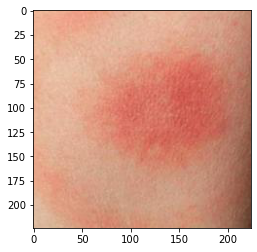

In [3]:
images, labels = next(iter(test_loader))
image = images[0]
image = image.numpy().transpose((1, 2, 0))
plt.imshow(image)
print(labels[0])

Retrieving VGG-11 model, because I dont think my computer can handle better

In [4]:
model = models.vgg11(pretrained=True)

/Users/evanwu/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/evanwu/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
#freeze features
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(nn.Linear(4096, 2048),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(2048, 1024),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(512, 2),
                           nn.LogSoftmax(dim=1))
model.classifier = classifier

Use MPS to speed up process

In [6]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
criterion = nn.NLLLoss()

optimizer = optim.SGD(model.classifier.parameters(), lr = 0.05)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

training time

In [ ]:
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        logits = model.forward(images)
        loss = criterion(logits, labels)
        loss.backward()
        model.step()
        running_loss += loss.item()
    else:
        accuracy = 0
        model.eval()
        #validation
        for images, labels, in test_loader:
            images, labels = images.to(device), labels.to(device)
            ps = torch.exp(model.forward(images, labels))
            top_probability, top_class = ps.topk(1, dim=1)
            equal = top_class == labels.view(*top_class.shape)
            accuracy += equal.sum().item()
        print(f"Epoch {e}/{e+1}")
        print(f"Test Accuracy {accuracy/len(test_loader.dataset)}")
        print(f"Train Loss {running_loss/len(train_loader)}")